# Test Var(N, m) Relation

In [1]:
from reduction import *
data_maps = {1: image_reduction(1), 2: image_reduction(2)}

In [2]:
from stack import *
inst = 1
filt_order = 3
ifield = 6
sample_type = 'jack_region'
dx = 1200
unmask=True

cbmap, psmap, strmask, strnum, mask_inst1, mask_inst2 = \
load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                    (inst,ifield,'psmap'),
                                   (inst,ifield,'strmask'), 
                                   (inst,ifield,'strnum'),
                                  (1,ifield,'mask_inst'),
                                   (2,ifield,'mask_inst')])
if inst==1:
    mask_inst = mask_inst1
else:
    mask_inst = mask_inst2

cbmap = image_poly_filter(cbmap, strmask*mask_inst, degree=filt_order)

In [93]:
Nsub = 16
# Nsigdata = {}
for im in range(4):
    Nsigdata[im] = {}
    
    m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]

    stacking_class = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                        load_from_file=True, BGsub=False, subsub=True)
    stackdat = stacking_class.stackdat
    cliplim = stacking_class._stackihl_PS_cliplim()

    srctype = 's'
    srcdat = ps_src_select(inst, ifield, m_min, m_max,
        [mask_inst1, mask_inst2], sample_type=sample_type, Nsub=Nsub)

    # start stacking
    rbinedges = stackdat['rbinedges']/0.7 # subpix unit
    rsubbinedges = stackdat['rsubbinedges']/0.7 # subpix unit

    Ilist_dict = {}
    Ilist_dict['Nsrc'] = np.zeros(Nsub)
    start_time = time.time()
    for isub in range(srcdat['Nsub']):
        stackdat['sub'][isub] = {}

        xls = srcdat['sub'][isub]['x' + srctype + '_arr']
        yls = srcdat['sub'][isub]['y' + srctype + '_arr']

        ms = srcdat['sub'][isub]['m' + srctype + '_arr']
        rs = get_mask_radius_th(ifield, ms) # arcsec

        print('stacking %s %d < m < %d, #%d subsample, %d sources, t = %.2f min'\
          %(fieldnamedict[ifield], m_min, m_max,isub,\
           len(xls), (time.time()-start_time)/60))

        Ilist_dict[isub] = []
        for i,(xl,yl,r) in enumerate(zip(xls,yls,rs)):
            cbmapi = cbmap*strmask*mask_inst
            psmapi = psmap*strmask*mask_inst
            maski = strmask*mask_inst
            radmap = make_radius_map(cbmap, xl,yl) # large pix units
            sp1 = np.where((radmap < r/7) & (strnum==1) & (mask_inst==1))
            cbmapi[sp1] = cbmap[sp1]
            psmapi[sp1] = psmap[sp1]
            unmaskpix = np.zeros_like(strmask)
            unmaskpix[sp1] = 1
            maski[sp1] = 1
            if len(sp1[0])>0 and unmask:
                for ibin in [0]:
                    if cliplim['CBmax'][ibin] == np.inf:
                        continue
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (cbmap > cliplim['CBmax'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (cbmap < cliplim['CBmin'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (psmap > cliplim['PSmax'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0
                    spi = np.where((unmaskpix==1) & \
                                   (radmap*10>=rbinedges[ibin]) & \
                                   (radmap*10 < rbinedges[ibin+1]) & \
                                   (psmap < cliplim['PSmin'][ibin]))
                    cbmapi[spi] = 0
                    psmapi[spi] = 0
                    maski[spi] = 0


            # unmask source
            mcb = cbmapi * maski
            mps = psmapi * maski
            xl, yl = int(np.round(xl)), int(np.round(yl))

            if maski[xl,yl]==1:
                Ilist_dict[isub].append(mcb[xl,yl])

        Ilist_dict['Nsrc'][isub] = len(Ilist_dict[isub])

    Nmin = np.min(Ilist_dict['Nsrc'])
    Nsrc_jk_arr = np.arange(Nmin).astype(int)+1
    sigma_arr = np.zeros(len(Nsrc_jk_arr))
    for iNsrc, Nsrc_jk in enumerate(Nsrc_jk_arr):
        Ijk = []
        for isub in range(Nsub):
            Ijk.append(np.mean(Ilist_dict[isub][:Nsrc_jk]))
        sigma_arr[iNsrc] = np.std(Ijk)
        
    Nsigdata[im] = {}
    Nsigdata[im]['N_arr'+srctype] = Nsrc_jk_arr*Nsub
    Nsigdata[im]['sig_arr'+srctype] = sigma_arr
clear_output()

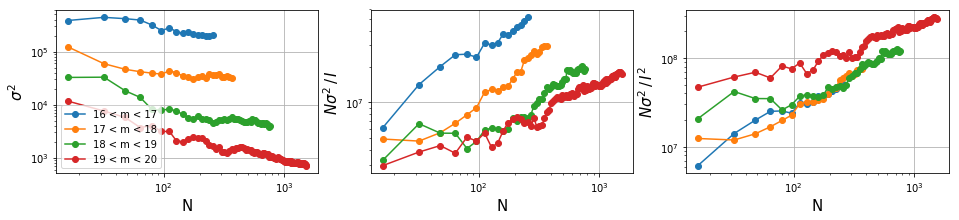

In [120]:
fig, ax = plt.subplots(1, 3, figsize = (16,3))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    N_arr = Nsigdata[im]['N_arr'+srctype]
    sig_arr = Nsigdata[im]['sig_arr'+srctype]
    I = 10**(-im/2.5)
    ax[0].loglog(N_arr, sig_arr**2,'o-', label='%d < m < %d'%(m_min, m_max))
    ax[1].loglog(N_arr, N_arr*sig_arr**2/I,'o-', label='%d < m < %d'%(m_min, m_max))
    ax[2].loglog(N_arr, N_arr*sig_arr**2/I**2,'o-', label='%d < m < %d'%(m_min, m_max))
ax[0].legend()
ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].set_xlabel('N',fontsize=15)
ax[1].set_xlabel('N',fontsize=15)
ax[2].set_xlabel('N',fontsize=15)
ax[0].set_ylabel(r'$\sigma^2$',fontsize=15)
ax[1].set_ylabel(r'$N\sigma^2\,/\,I$',fontsize=15)
ax[2].set_ylabel(r'$N\sigma^2\,/\,I^2$',fontsize=15)
plt.savefig('/Users/ytcheng/Desktop/cov_scale.png', dpi = 150,bbox_inches='tight')

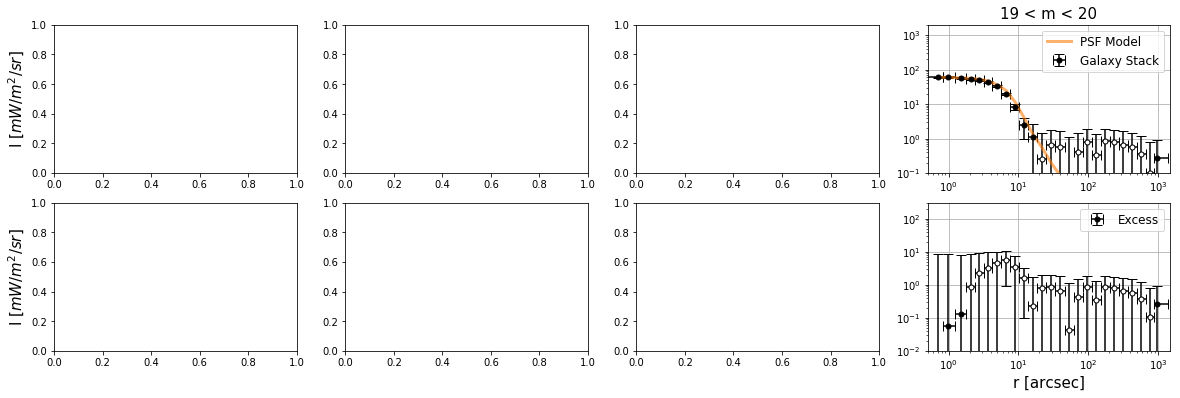

In [181]:
from stack import *
inst = 1
ifield = 5
im = 3
m_min, m_max = magbindict['m_min'][im],magbindict['m_max'][im]

fig, ax = plt.subplots(2, 4, figsize = (20,6))
filt_order = filt_order_dict[inst]
stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                    load_from_file=True, BGsub=False).stackdat

plot_err_log(stackdat['rbins'], 
             stackdat['profcb'],
             np.sqrt(np.diag(stackdat['cov']['profcb'])),
             ax=ax[0][im], color='k',label='Galaxy Stack')
ax[0][im].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
              'C1', alpha=0.6, lw=3, label='PSF Model')
#             plot_err_log(stackdat['rbins']*1.01, 
#                          stackdat['BG']['profcb'],
#                          np.sqrt(np.diag(stackdat['BGcov']['profcb'])),
#                          ax=ax[0][im], color='C0', label='Background Stack')
ax[0][im].set_ylim([1e-1,2e3])
ax[0][im].set_xlim([5e-1,1.5e3])
ax[0][im].grid()    
ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)

plot_err_log(stackdat['rbins'], 
             stackdat['ex']['profcb'],
             np.sqrt(np.diag(stackdat['excov']['profcb'])),
             ax=ax[1][im], color='k',label='Excess')

# PSFscaled = stackdat['PSF']['profcb']/stackdat['PSF']['profcb'][8]*stackdat['profcb'][8]
# ex = stackdat['profcb'] - PSFscaled
# plot_err_log(stackdat['rbins'], 
#              ex,
#              np.sqrt(np.diag(stackdat['excov']['profcb'])),
#              ax=ax[1][im], color='k',label='Excess')


ax[1][im].set_ylim([1e-2,3e2])
ax[1][im].set_xlim([5e-1,1.5e3])
ax[1][im].grid()    
ax[1][im].set_xlabel('r [arcsec]', fontsize=15)

ax[0][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
ax[1][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
ax[0][-1].legend(fontsize=12)
ax[1][-1].legend(fontsize=12)

In [174]:
im = 3
ifield = 8
m_min, m_max = magbindict['m_min'][im],magbindict['m_max'][im]

stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                    load_from_file=True, BGsub=False).stackdat
stackdat['profcb'][0]/stackdat['profcb'][1],stackdat['PSF']['profcb'][0]/stackdat['PSF']['profcb'][1]

(1.0163174939736164, 1.0138732827815544)

(array([70.10591289, 68.98032682]),
 array([1.26160000e+04, 1.26230000e+04, 3.79600000e+04, 5.05350000e+04,
        7.56770000e+04, 1.50867000e+05, 2.74740000e+05, 5.17082000e+05,
        9.04016000e+05, 1.61001200e+06, 2.97730600e+06, 5.35382800e+06,
        9.54386400e+06, 1.75725880e+07, 3.19163570e+07, 5.76911170e+07,
        1.04007809e+08, 1.87503367e+08, 3.38166298e+08, 6.07148201e+08,
        1.08743202e+09, 1.93098919e+09, 3.41652808e+09, 5.64879354e+09,
        2.28531892e+09]))

In [236]:
inst = 1
ifield = 5
im = 3
m_min, m_max = magbindict['m_min'][im],magbindict['m_max'][im]

import json
loaddir = mypaths['alldat']+'TM' + str(inst) + '/'
with open(loaddir + fieldnamedict[ifield] + '_datafit.json') as json_file:
    data_all = json.load(json_file)

data =data_all[im]
radmap = make_radius_map(np.zeros([2*dx+1, 2*dx+1]), dx, dx)*0.7
tck = interpolate.splrep(np.log(np.array(data['rfull_arr'])[:16]),
                         np.log(np.array(data['profpsf'])[:16]), k=1)
radmap[dx,dx] = radmap[dx,dx+1]
psfwin_map = np.exp(interpolate.splev(np.log(radmap),tck))
psfwin_map[psfwin_map < 0] = 0
profpsf = radial_prof(psfwin_map, dx, dx)
profpsf_old = np.array(profpsf['prof'])
profpsf_old /= profpsf_old[0]

stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                    load_from_file=True, BGsub=False).stackdat
profpsf_arr = stackdat['PSF']['profcb'] / stackdat['PSF']['profcb'][0]
profgal_arr = stackdat['profcb'] / stackdat['profcb'][0]

In [254]:
profpsf_old/profpsf_arr

array([ 1.        ,  0.99347236,  0.99974973,  0.97212782,  0.94608142,
        0.93274614,  0.89310741,  0.78856438,  0.73444603,  0.64822734,
        0.52199297,  0.32727935,  0.27442826,  0.22984555,  0.19736609,
        0.21181775,  0.20438575,  0.25702188,  0.28423483, -1.18910037,
       -0.08923729, -0.06498502, -0.02978576, -0.01109538, -0.00433109])

In [234]:
stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                    load_from_file=True, BGsub=False).stackdat
profpsf_arr = stackdat['PSF']['profcb'] / stackdat['PSF']['profcb'][0]
profgal_arr = stackdat['profcb'] / stackdat['profcb'][0]

profgal_arr/profpsf_arr

array([ 1.00000000e+00,  9.87392298e-01,  1.02104460e+00,  1.03518332e+00,
        1.04453266e+00,  1.06843074e+00,  1.10382331e+00,  1.15522981e+00,
        1.43595534e+00,  2.21049518e+00,  6.83526296e+00,  1.20398269e+01,
        2.80358991e+01,  5.68686279e+01,  9.63488460e+01,  1.87191054e+02,
        8.86764240e+02,  2.04936754e+03,  7.70546572e+03,  1.43311175e+04,
        1.76172559e+06, -7.47682563e+03, -3.34966503e+03, -3.54852797e+03,
       -2.51172253e+03])

In [235]:
stackdat['profcb']/stackdat['PSF']['profcb'], stackdat['ex']['profcb']

(array([ 1.00000000e+00,  9.87392298e-01,  1.02104460e+00,  1.03518332e+00,
         1.04453266e+00,  1.06843074e+00,  1.10382331e+00,  1.15522981e+00,
         1.43595534e+00,  2.21049518e+00,  6.83526296e+00,  1.20398269e+01,
         2.80358991e+01,  5.68686279e+01,  9.63488460e+01,  1.87191054e+02,
         8.86764240e+02,  2.04936754e+03,  7.70546572e+03,  1.43311175e+04,
         1.76172559e+06, -7.47682563e+03, -3.34966503e+03, -3.54852797e+03,
        -2.51172253e+03]),
 array([ 0.        , -1.13697264,  1.7944615 ,  2.81287862,  3.2701267 ,
         4.33842407,  5.04219219,  4.69510246,  5.27145097,  3.67457255,
         3.16993985,  2.35866553,  1.98431716,  1.55891505,  1.04493419,
         0.78752857,  1.44119776,  1.29442007,  1.35755452,  1.14808274,
         1.13540361,  1.11607493,  1.01560346,  0.9886454 ,  0.81376495]))

In [225]:
profgal_arr/profpsf_old

array([ 1.00000000e+00,  1.00752091e+00,  1.00257712e+00,  1.01330830e+00,
        1.01071616e+00,  1.00088721e+00,  9.85281619e-01,  9.88381142e-01,
        9.55540642e-01,  9.27490827e-01,  1.58951528e+00, -1.38810630e+00,
       -1.17570877e+01, -2.87617874e+01, -5.04900861e-01, -1.21567828e+02,
       -5.36430524e+02, -4.84061535e+02, -2.61999809e+03, -5.34641629e+03,
       -9.34823309e+03, -1.81503939e+04, -2.52240573e+04, -1.55059161e+04,
        7.57620689e+04])

In [280]:
        srcdat = ps_src_select(inst, ifield, m_min, m_max, 
            [mask_inst1, mask_inst2], sample_type='all')


In [ ]:
def run_psf_synth_temp(inst, ifield, filt_order=3, savedata=True):

    fname = mypaths['alldat'] + 'TM'+ str(inst) + \
    '/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
    with open(fname, "rb") as f:
        profdat = pickle.load(f)

    data_maps = {1: image_reduction(1), 2: image_reduction(2)}

    if savedata:
        fname = mypaths['alldat'] + 'TM'+ str(inst) +\
         '/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
        with open(fname, "wb") as f:
            pickle.dump(profdat, f)
    
    mapin, strmask, strnum, mask_inst1, mask_inst2 = \
    load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                       (inst,ifield,'strmask'), 
                                       (inst,ifield,'strnum'),
                                       (1,ifield,'mask_inst'),
                                       (2,ifield,'mask_inst')])
    
    for im, (m_min, m_max) in enumerate(zip(magbindict['m_min'], magbindict['m_max'])):
        if im !=3:
            continue
        stack_class = stacking(inst, ifield, m_min, m_max, filt_order=filt_order, 
                            load_from_file=True,BGsub=False)

        cliplim = stack_class._stackihl_PS_cliplim()

        srcdat = ps_src_select(inst, ifield, m_min, m_max, 
            [mask_inst1, mask_inst2], sample_type='jack_region')

        stackdat = stack_class.stack_PS(srctype='s',cliplim=cliplim, 
                                        srcdat=srcdat, verbose=False)
        stack_class.stackdat = stackdat
        stack_class._get_jackknife_profile()
        stack_class._get_covariance()

        profdat[im] = {}
        profdat[im]['m_min'] = m_min
        profdat[im]['m_max'] = m_max
        profdat[im]['Nsrc'] = stackdat['Nsrc']
        profdat[im]['profcb'] = stack_class.stackdat['profcb']
        profdat[im]['profcb_err'] = np.sqrt(np.diag(stackdat['cov']['profcb']))
        profdat[im]['profcbsub'] = stack_class.stackdat['profcbsub']
        profdat[im]['profcbsub_err'] = np.sqrt(np.diag(stackdat['cov']['profcbsub']))
        profdat[im]['cov'] = stackdat['cov']['profcb']
        profdat[im]['covsub'] = stackdat['cov']['profcbsub']

        if savedata:
            fname = mypaths['alldat'] + 'TM'+ str(inst) +\
             '/psfdata_synth_%s.pkl'%(fieldnamedict[ifield])
            with open(fname, "wb") as f:
                pickle.dump(profdat, f)
        
    if savedata:
        return
    
    return profdat

In [297]:
start_time = time.time()
stacking_class = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                    load_from_file=True, BGsub=False, subsub=True)
cliplim = stacking_class._stackihl_PS_cliplim(Nsrc=np.inf)
time.time() - start_time

379.48069286346436

In [298]:
cliplim['CBmax'],cliplim['CBmin']

(array([918.35782349, 918.35782349, 918.35782349, 918.35782349,
        875.72389406, 852.60560697, 824.25152994, 790.52017883,
        782.91272687, 772.7754739 , 741.36287323,          inf,
                 inf,          inf,          inf,          inf,
                 inf,          inf,          inf,          inf,
                 inf,          inf,          inf,          inf,
                 inf]),
 array([-786.303953  , -786.303953  , -786.303953  , -786.303953  ,
        -783.74265966, -765.35934375, -764.11468549, -758.20961828,
        -774.62305663, -770.14606467, -742.41454078,          -inf,
                 -inf,          -inf,          -inf,          -inf,
                 -inf,          -inf,          -inf,          -inf,
                 -inf,          -inf,          -inf,          -inf,
                 -inf]))

In [18]:

if srcdat['N' + srctype] < 64:
    srcdat = ps_src_select(inst, ifield, m_min, m_max, 
        [mask_inst1, mask_inst2], sample_type='jack_random',
        Nsub=srcdat['N' + srctype])

# init stackdat
stackdat = {}
stackdat['rbins'] = cliplim['rbins']
stackdat['rbinedges'] = cliplim['rbinedges']
stackdat['rsubbins'],stackdat['rsubbinedges'] =\
stacking_class._radial_binning(cliplim['rbins'], cliplim['rbinedges'])
stackdat['inst']= inst
stackdat['ifield'] = ifield
stackdat['field'] = fieldnamedict[ifield]
stackdat['m_min'], stackdat['m_max'] = m_min, m_max
stackdat['Nsrc'] = srcdat['N' + srctype]
stackdat['Nsub'] = srcdat['Nsub']
stackdat['sub'] = {}

# start stacking
Nbins = len(stackdat['rbins'])
Nsubbins = len(stackdat['rsubbins'])
radmapstamp =  make_radius_map(np.zeros((2*dx+1, 2*dx+1)), dx, dx) # subpix unit
rbinedges = stackdat['rbinedges']/0.7 # subpix unit
rsubbinedges = stackdat['rsubbinedges']/0.7 # subpix unit

cbmapstack, psmapstack, maskstack =\
 np.zeros([2*dx+1, 2*dx+1]),np.zeros([2*dx+1, 2*dx+1]), np.zeros([2*dx+1, 2*dx+1])
start_time = time.time()

In [52]:
inst = 1
ifield = 8
cbmap, psmap, strmask, strnum, mask_inst1, mask_inst2 = \
load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                    (inst,ifield,'psmap'),
                                   (inst,ifield,'strmask'), 
                                   (inst,ifield,'strnum'),
                                   (1,ifield,'mask_inst'),
                                   (2,ifield,'mask_inst')])
if inst==1:
    mask_inst = mask_inst1
else:
    mask_inst = mask_inst2

srcdat = ps_src_select(inst, ifield, m_min, m_max, 
    [mask_inst1, mask_inst2], sample_type=sample_type)

Nsub = 64
Nsides = int(np.sqrt(Nsub))
axlims = np.linspace(-0.5, 1023.5, Nsides+1)
ymins, xmins = np.meshgrid(axlims[:-1], axlims[:-1])
ymaxs, xmaxs = np.meshgrid(axlims[1:], axlims[1:])
meang_all = 0
means_all = 0
for isub in range(srcdat['Nsub']):
    xls = np.round(srcdat['sub'][isub]['x' + srctype + '_arr']).astype('int') 
    yls = np.round(srcdat['sub'][isub]['' + srctype + '_arr']).astype('int') 

#     cbmap[xls]
#     ymin, xmin = int(ymins.flatten()[isub]+0.5), int(xmins.flatten()[isub]+0.5)
#     ymax, xmax = int(ymaxs.flatten()[isub]-0.5), int(xmaxs.flatten()[isub]-0.5)
#     meanmap_sub = np.mean((cbmap*strmask*mask_inst)[xmin:xmax,ymin:ymax])
#     meang_all += meanmap_sub*srcdat['sub'][isub]['Ng']
#     means_all += meanmap_sub*srcdat['sub'][isub]['Ns']
# print(meang_all/srcdat['Ng'], means_all/srcdat['Ns'])

In [54]:
cbmap[xls,yls],(mask_inst*strmask)[xls,yls]

(array([ 178.27514877,   37.70603868,   59.77282469,  -59.35229833,
         170.2734071 ,  -99.83680393,   -1.67040771,   50.31034598,
           5.76362532,   61.17623991,  -23.87209702,  505.145408  ,
         114.44901087,   14.69240007,  -42.71915275,   24.29144431,
          66.89159176,  132.22849681,  184.49448974,   -3.6801591 ,
        -134.14301042,  140.42642053,  -23.20630458,  -73.15741111,
         -78.38168027,   47.21894876,  -13.77074632,  211.36377696,
         -86.93367119,  -38.19849211,  177.86443487]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [13]:
from run_fit import *
param_fit = fit_stacking_mcmc(inst, ifield, im, filt_order)
srcdat = ps_src_select(inst, ifield, m_min, m_max, 
    [mask_inst1, mask_inst2], sample_type=sample_type)

In [22]:
inst = 1
ifield = 6
m_min, m_max = 19,20
stacking_class = stacking(inst,ifield,m_min,m_max, filt_order=filt_order,
                    load_from_file=True, BGsub=False)
stackdat = stacking_class.stackdat
srcdat = ps_src_select(inst, ifield, m_min, m_max, 
    [mask_inst1, mask_inst2], sample_type=sample_type)

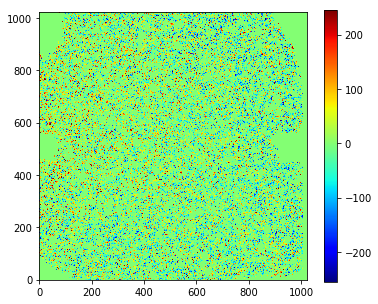

In [116]:
imageclip(cbmap*strmask*mask_inst)

In [59]:
from stack import *
inst = 1
filt_order = 3
ifield = 5
im = 3
m_min, m_max = magbindict['m_min'][im], magbindict['m_max'][im]
sample_type = 'jack_region'
srctype = 'g'
dx = 1200
unmask=True
stacking_class = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                    load_from_file=True, BGsub=False)
stackdat = stacking_class.stackdat
cliplim = stacking_class._stackihl_PS_cliplim()

In [98]:
srctype = 'g'
Nsub = 64
Nsides = int(np.sqrt(Nsub))
axlims = np.linspace(-0.5, 1023.5, Nsides+1)
ymins, xmins = np.meshgrid(axlims[:-1], axlims[:-1])
ymaxs, xmaxs = np.meshgrid(axlims[1:], axlims[1:])

Nbins = len(stackdat['rbins'])
Nsubbins = len(stackdat['rsubbins'])
# radmapstamp =  make_radius_map(np.zeros((2*dx+1, 2*dx+1)), dx, dx) # subpix unit
rbinedges = stackdat['rbinedges']/0.7 # subpix unit
rsubbinedges = stackdat['rsubbinedges']/0.7 # subpix unit
start_time = time.time()
Ilistg1=np.array([])
Ilistg3=np.array([])
for isub in range(srcdat['Nsub']):
    ymin, xmin = int(ymins.flatten()[isub]+0.5), int(xmins.flatten()[isub]+0.5)
    ymax, xmax = int(ymaxs.flatten()[isub]-0.5), int(xmaxs.flatten()[isub]-0.5)
    meanmap_sub = np.mean((cbmap*strmask*mask_inst)[xmin:xmax,ymin:ymax])
    
    stackdat['sub'][isub] = {}

    xls = srcdat['sub'][isub]['x' + srctype + '_arr']
    yls = srcdat['sub'][isub]['y' + srctype + '_arr']
    
    stackdat['sub'][isub]['Nsrc'] = len(xls)
    if len(xls) == 0:
        stackdat['sub'][isub]['profcb'] = np.zeros(Nbins)
        stackdat['sub'][isub]['profps'] = np.zeros(Nbins)
        stackdat['sub'][isub]['profhit'] = np.zeros(Nbins)
        stackdat['sub'][isub]['profcbsub'] = np.zeros(Nsubbins)
        stackdat['sub'][isub]['profpssub'] = np.zeros(Nsubbins)
        stackdat['sub'][isub]['profhitsub'] = np.zeros(Nsubbins)
        stackdat['sub'][isub]['profcb100'] = 0
        stackdat['sub'][isub]['profps100'] = 0
        stackdat['sub'][isub]['profhit100'] = 0
        continue

    xss = np.round(xls * 10 + 4.5).astype(np.int32)
    yss = np.round(yls * 10 + 4.5).astype(np.int32)
    ms = srcdat['sub'][isub]['m' + srctype + '_arr']
    rs = get_mask_radius_th(ifield, ms) # arcsec
    
    print('stacking %s %d < m < %d, #%d subsample, %d sources, t = %.2f min'\
      %(fieldnamedict[ifield], m_min, m_max,isub,\
       len(xls), (time.time()-start_time)/60))

    for i,(xl,yl,xs,ys,r) in enumerate(zip(xls,yls,xss,yss,rs)):
        cbmapi = cbmap*strmask*mask_inst
        psmapi = psmap*strmask*mask_inst
        maski = strmask*mask_inst
        radmap = make_radius_map(cbmap, xl,yl) # large pix units
        sp1 = np.where((radmap < r/7) & (strnum==1) & (mask_inst==1))
        cbmapi[sp1] = cbmap[sp1]
        psmapi[sp1] = psmap[sp1]
        unmaskpix = np.zeros_like(strmask)
        unmaskpix[sp1] = 1
        maski[sp1] = 1
        if len(sp1[0])>0 and unmask:
            for ibin in range(Nbins):
                if cliplim['CBmax'][ibin] == np.inf:
                    continue
                spi = np.where((unmaskpix==1) & \
                               (radmap*10>=rbinedges[ibin]) & \
                               (radmap*10 < rbinedges[ibin+1]) & \
                               (cbmap > cliplim['CBmax'][ibin]))
                cbmapi[spi] = 0
                psmapi[spi] = 0
                maski[spi] = 0
                spi = np.where((unmaskpix==1) & \
                               (radmap*10>=rbinedges[ibin]) & \
                               (radmap*10 < rbinedges[ibin+1]) & \
                               (cbmap < cliplim['CBmin'][ibin]))
                cbmapi[spi] = 0
                psmapi[spi] = 0
                maski[spi] = 0
                spi = np.where((unmaskpix==1) & \
                               (radmap*10>=rbinedges[ibin]) & \
                               (radmap*10 < rbinedges[ibin+1]) & \
                               (psmap > cliplim['PSmax'][ibin]))
                cbmapi[spi] = 0
                psmapi[spi] = 0
                maski[spi] = 0
                spi = np.where((unmaskpix==1) & \
                               (radmap*10>=rbinedges[ibin]) & \
                               (radmap*10 < rbinedges[ibin+1]) & \
                               (psmap < cliplim['PSmin'][ibin]))
                cbmapi[spi] = 0
                psmapi[spi] = 0
                maski[spi] = 0


        # unmask source
        mcb = cbmapi * maski
        mps = psmapi * maski
        xl, yl = int(np.round(xl)), int(np.round(yl))
        
        if maski[xl,yl]==1:
            Ilistg1=np.concatenate((Ilistg1,[mcb[xl,yl]]))
        mapi = mcb[xl-1:xl+2, yl-1:yl+2]
        maski = maski[xl-1:xl+2, yl-1:yl+2]
        
        if mapi.shape!=(3,3):
            continue
        maski[1,1] = 0
        if np.sum(maski)!=0:
#             print(np.mean(mapi[maski==1]))
            Ilistg3=np.concatenate((Ilistg3,mapi[maski==1]))
        
clear_output()
#         if maski[xl, yl]!=0:
#             if mcb[xl, yl] < -300:
#                 print(isub,mcb[int(np.round(xl)), int(np.round(yl))])

In [99]:
srctype = 's'
Nsub = 64
Nsides = int(np.sqrt(Nsub))
axlims = np.linspace(-0.5, 1023.5, Nsides+1)
ymins, xmins = np.meshgrid(axlims[:-1], axlims[:-1])
ymaxs, xmaxs = np.meshgrid(axlims[1:], axlims[1:])

Nbins = len(stackdat['rbins'])
Nsubbins = len(stackdat['rsubbins'])
# radmapstamp =  make_radius_map(np.zeros((2*dx+1, 2*dx+1)), dx, dx) # subpix unit
rbinedges = stackdat['rbinedges']/0.7 # subpix unit
rsubbinedges = stackdat['rsubbinedges']/0.7 # subpix unit
start_time = time.time()
Ilists1=np.array([])
Ilists3=np.array([])
for isub in range(srcdat['Nsub']):
    ymin, xmin = int(ymins.flatten()[isub]+0.5), int(xmins.flatten()[isub]+0.5)
    ymax, xmax = int(ymaxs.flatten()[isub]-0.5), int(xmaxs.flatten()[isub]-0.5)
    meanmap_sub = np.mean((cbmap*strmask*mask_inst)[xmin:xmax,ymin:ymax])
    
    stackdat['sub'][isub] = {}

    xls = srcdat['sub'][isub]['x' + srctype + '_arr']
    yls = srcdat['sub'][isub]['y' + srctype + '_arr']
    
    stackdat['sub'][isub]['Nsrc'] = len(xls)
    if len(xls) == 0:
        stackdat['sub'][isub]['profcb'] = np.zeros(Nbins)
        stackdat['sub'][isub]['profps'] = np.zeros(Nbins)
        stackdat['sub'][isub]['profhit'] = np.zeros(Nbins)
        stackdat['sub'][isub]['profcbsub'] = np.zeros(Nsubbins)
        stackdat['sub'][isub]['profpssub'] = np.zeros(Nsubbins)
        stackdat['sub'][isub]['profhitsub'] = np.zeros(Nsubbins)
        stackdat['sub'][isub]['profcb100'] = 0
        stackdat['sub'][isub]['profps100'] = 0
        stackdat['sub'][isub]['profhit100'] = 0
        continue

    xss = np.round(xls * 10 + 4.5).astype(np.int32)
    yss = np.round(yls * 10 + 4.5).astype(np.int32)
    ms = srcdat['sub'][isub]['m' + srctype + '_arr']
    rs = get_mask_radius_th(ifield, ms) # arcsec
    
    print('stacking %s %d < m < %d, #%d subsample, %d sources, t = %.2f min'\
      %(fieldnamedict[ifield], m_min, m_max,isub,\
       len(xls), (time.time()-start_time)/60))

    for i,(xl,yl,xs,ys,r) in enumerate(zip(xls,yls,xss,yss,rs)):
        cbmapi = cbmap*strmask*mask_inst
        psmapi = psmap*strmask*mask_inst
        maski = strmask*mask_inst
        radmap = make_radius_map(cbmap, xl,yl) # large pix units
        sp1 = np.where((radmap < r/7) & (strnum==1) & (mask_inst==1))
        cbmapi[sp1] = cbmap[sp1]
        psmapi[sp1] = psmap[sp1]
        unmaskpix = np.zeros_like(strmask)
        unmaskpix[sp1] = 1
        maski[sp1] = 1
        if len(sp1[0])>0 and unmask:
            for ibin in range(Nbins):
                if cliplim['CBmax'][ibin] == np.inf:
                    continue
                spi = np.where((unmaskpix==1) & \
                               (radmap*10>=rbinedges[ibin]) & \
                               (radmap*10 < rbinedges[ibin+1]) & \
                               (cbmap > cliplim['CBmax'][ibin]))
                cbmapi[spi] = 0
                psmapi[spi] = 0
                maski[spi] = 0
                spi = np.where((unmaskpix==1) & \
                               (radmap*10>=rbinedges[ibin]) & \
                               (radmap*10 < rbinedges[ibin+1]) & \
                               (cbmap < cliplim['CBmin'][ibin]))
                cbmapi[spi] = 0
                psmapi[spi] = 0
                maski[spi] = 0
                spi = np.where((unmaskpix==1) & \
                               (radmap*10>=rbinedges[ibin]) & \
                               (radmap*10 < rbinedges[ibin+1]) & \
                               (psmap > cliplim['PSmax'][ibin]))
                cbmapi[spi] = 0
                psmapi[spi] = 0
                maski[spi] = 0
                spi = np.where((unmaskpix==1) & \
                               (radmap*10>=rbinedges[ibin]) & \
                               (radmap*10 < rbinedges[ibin+1]) & \
                               (psmap < cliplim['PSmin'][ibin]))
                cbmapi[spi] = 0
                psmapi[spi] = 0
                maski[spi] = 0


        # unmask source
        mcb = cbmapi * maski
        mps = psmapi * maski
        xl, yl = int(np.round(xl)), int(np.round(yl))
        
        if maski[xl,yl]==1:
            Ilists1=np.concatenate((Ilists1,[mcb[xl,yl]]))
        mapi = mcb[xl-1:xl+2, yl-1:yl+2]
        maski = maski[xl-1:xl+2, yl-1:yl+2]
        
        if mapi.shape!=(3,3):
            continue
        maski[1,1] = 0
        if np.sum(maski)!=0:
#             print(np.mean(mapi[maski==1]))
            Ilists3=np.concatenate((Ilists3,mapi[maski==1]))
        
clear_output()
#         if maski[xl, yl]!=0:
#             if mcb[xl, yl] < -300:
#                 print(isub,mcb[int(np.round(xl)), int(np.round(yl))])

In [101]:
np.mean(Ilistg1),np.mean(Ilistg3)

(71.27763471585506, 14.627815461222491)

In [100]:
np.mean(Ilists1),np.mean(Ilists3)

(52.721677007632586, 9.130618394620422)

In [103]:
71/14,53/9

(5.071428571428571, 5.888888888888889)

In [81]:
np.mean(Ilist1),np.mean(Ilist3)

(8.64688743570368, 3.947862266873427)

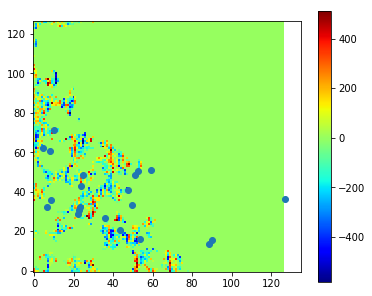

In [63]:
imageclip(mcb[xmin:xmax,ymin:ymax])
plt.scatter(xls-xmin,yls-ymin)

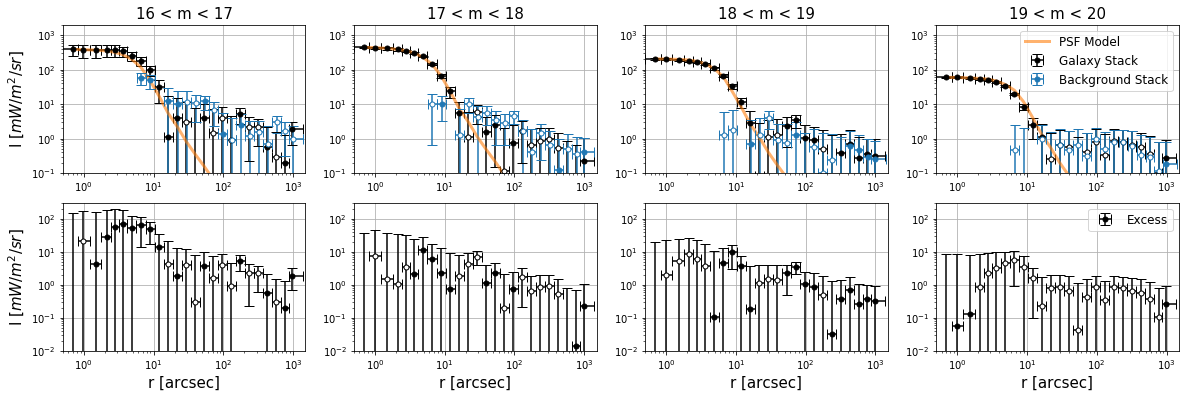

In [5]:
from stack import *

for ifield in [5]:
    for inst in [1]:
        plt.close()
        fig, ax = plt.subplots(2, 4, figsize = (20,6))
        filt_order = filt_order_dict[inst]
        for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
            stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                                load_from_file=True, BGsub=False).stackdat

            plot_err_log(stackdat['rbins'], 
                         stackdat['profcb'],
                         np.sqrt(np.diag(stackdat['cov']['profcb'])),
                         ax=ax[0][im], color='k',label='Galaxy Stack')
            ax[0][im].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
                          'C1', alpha=0.6, lw=3, label='PSF Model')
            plot_err_log(stackdat['rbins']*1.01, 
                         stackdat['BG']['profcb'],
                         np.sqrt(np.diag(stackdat['BGcov']['profcb'])),
                         ax=ax[0][im], color='C0', label='Background Stack')
            ax[0][im].set_ylim([1e-1,2e3])
            ax[0][im].set_xlim([5e-1,1.5e3])
            ax[0][im].grid()    
            ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)

            plot_err_log(stackdat['rbins'], 
                         stackdat['ex']['profcb'],
                         np.sqrt(np.diag(stackdat['excov']['profcb'])),
                         ax=ax[1][im], color='k',label='Excess')
            ax[1][im].set_ylim([1e-2,3e2])
            ax[1][im].set_xlim([5e-1,1.5e3])
            ax[1][im].grid()    
            ax[1][im].set_xlabel('r [arcsec]', fontsize=15)

        ax[0][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
        ax[1][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
        ax[0][-1].legend(fontsize=12)
        ax[1][-1].legend(fontsize=12)

#         plt.savefig('plots/paperfig/profile_TM%d_%s.pdf'%(inst, fieldnamedict[ifield]),
#                     dpi = 150, bbox_inches='tight')

In [73]:
prof_avg - stackdat['PSF']['profcb']*prof_avg[0]/stackdat['PSF']['profcb'][0]


array([ 0.        ,  0.6507416 ,  0.04781495, -0.95074533, -1.81606285,
       -2.05512341, -2.90471699, -4.54522986, -2.68678533, -2.04944928,
       -1.23320196, -0.93299575, -0.8379738 ,  0.24336092, -0.04653527,
       -0.46433289, -0.81249797, -0.25615645, -0.28015583, -0.14852061,
       -0.12680891, -0.14810495, -0.0394445 ,  0.11055847,  0.23692791])

In [74]:
prof_avg1 - stackdat['PSF']['profcb']*prof_avg[0]/stackdat['PSF']['profcb'][0]

array([ 2.77336704,  3.33014352,  2.46321681,  1.2031267 , -0.11189836,
       -0.8751687 , -2.20666082, -4.4079642 , -2.73620078, -1.75804154,
       -0.71360407, -0.6089667 , -0.54100276,  0.69572679,  0.22547712,
       -0.16105394, -0.5219467 ,  0.19453353,  0.05467327,  0.02376524,
        0.20286031,  0.05374733,  0.21312893,  0.33667588,  0.44885824])

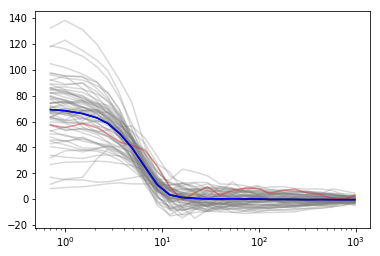

In [89]:
rbins = stackdat['rbins']
profs = []
profs1 = []
for isub in range(stackdat['Nsub']):
    prof = stackdat['sub'][isub]['profcb']
    plt.semilogx(rbins, prof,'grey',alpha=0.3)
    profs.append(prof)
    if prof[0]>-100:# and prof[0]<150:
        profs1.append(prof)
#     else:
#         plt.semilogx(rbins, prof,'r',alpha=0.3)   
    if isub==63:
        plt.semilogx(rbins, prof,'r',alpha=0.3) 
        
prof_avg = np.mean(np.array(profs),axis=0)
prof_avg1 = np.mean(np.array(profs1),axis=0)
plt.semilogx(rbins, prof_avg, 'k')
plt.semilogx(rbins, prof_avg1, 'b')
#     print(stackdat['sub'][isub]['Nsrc'])
#     if any(prof<-100):
#         print(isub,stackdat['sub'][isub]['Nsrc'])